### Import Libraries

In [976]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

In [977]:
%load_ext autoreload
%autoreload 2
from streamer import Streamer
from attack import Attacker
from edgearea import EdgeArea, IDS, VideoServer
from resource_allocation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define Environment

In [978]:
def generate_attack_intensity(time_steps, baseline, fluctuation, spike_prob, spike_intensity, 
                                             persistence_coeffs, decay_factor, drop_prob, drop_intensity):
    # Initialize intensity array with the first three values set to baseline
    intensity = np.full(time_steps, baseline)
    
    # Generate time series with AR(3) process with decay and drop probability
    for t in range(3, time_steps):
        # AR(3) process with decay factor
        intensity[t] = (
            persistence_coeffs[0] * intensity[t - 1] +
            persistence_coeffs[1] * intensity[t - 2] +
            persistence_coeffs[2] * intensity[t - 3] +
            (1 - sum(persistence_coeffs)) * baseline +
            np.random.normal(0, fluctuation)
        )
        
        # Apply decay factor to gradually reduce intensity toward baseline
        # intensity[t] *= (1 - decay_factor)
        
        # Add random spikes
        if np.random.rand() < spike_prob:
            intensity[t] += spike_intensity
        
        # Randomly drop the intensity with a certain probability
        if np.random.rand() < drop_prob:
            intensity[t] -= drop_intensity
            # Ensure the intensity does not go below zero
            intensity[t] = max(intensity[t], baseline)
        intensity[t] = max(0, intensity[t])
        intensity[t] = min(2000, intensity[t])

    return intensity

def generate_hsmm(n_steps, states, duration_means, transition_matrix, plot=False):
    def simulate_duration(mean_duration):
        return np.random.poisson(mean_duration)    
    def select_next_state(current_state):
        return np.random.choice(states, p=transition_matrix[states.index(current_state)])

     
    current_state = random.choice(states)  # randomly choose initial state
    state_sequence = [current_state]  # keep track of the states over time
    duration_in_current_state = simulate_duration(duration_means[states.index(current_state)])
    time_in_state = 0  # initialize time spent in the current state
    # Simulate HSMM process with "No Attack" state
    for t in range(1, n_steps):
        if time_in_state < duration_in_current_state:
            # Stay in the current state
            state_sequence.append(current_state)
            time_in_state += 1
        else:
            # Transition to the next state
            current_state = select_next_state(current_state)
            state_sequence.append(current_state)
            duration_in_current_state = simulate_duration(duration_means[states.index(current_state)])
            time_in_state = 1  # Reset time in the new state    
    if plot:
        # Plot the sequence of states over time
        plt.figure(figsize=(20, 3))
        plt.plot(range(n_steps), state_sequence, marker='o')
        plt.yticks(range(len(states)), states)
        plt.title('Hidden Semi-Markov Model')
        plt.xlabel('Time Step')
        plt.ylabel('Attack Variant')
        plt.grid(True)
        plt.show()        

    return state_sequence

In [979]:
# Use the Solarize Light style globally
plt.style.use("Solarize_Light2")

# Set global parameters for black axes, labels, and grid
plt.rcParams['grid.color'] = 'white'               # Grid color
plt.rcParams['grid.linestyle'] = '--'              # Grid linestyle
plt.rcParams['grid.alpha'] = 0.7                   # Grid transparency
plt.rcParams['axes.edgecolor'] = 'black'           # Axis border color
plt.rcParams['axes.labelcolor'] = 'black'          # Axis label color
plt.rcParams['xtick.color'] = 'black'              # X-axis tick color
plt.rcParams['ytick.color'] = 'black'              # Y-axis tick color
plt.rcParams['text.color'] = 'black'               # Default text color, affects title color

In [1151]:

# atk_states = ["NoAtk", "DDoS", "SYN Flood", "HTTP Flood"]
atk_states = ["NoAtk", "bonesi", "goldeneye", "hulk"]
# atk_states = ["NoAtk", "bonesi", "bonesi", "bonesi"]
# atk_states = ["NoAtk", "hulk", "hulk", "hulk"]
atk_duration_means = [5, 3, 2, 4]  # mean duration for each state (Poisson distribution)
atk_transition_matrix = np.array(  [[0.6, 0.1, 0.15, 0.15],  # No Attack
                                    [0.1, 0.7, 0.1, 0.1],  # DDoS
                                    [0.1, 0.1, 0.7, 0.1],  # SYN Flood
                                    [0.1, 0.1, 0.2, 0.6]])  # HTTP Flood   

stream_states = [0, 1] #0: Idle, #1: Streaming
stream_duration_means = [20, 30]  # mean duration for each state (Poisson distribution)
stream_transition_matrix = np.array([[0.3, 0.7],  # Idle
                                     [0.8, 0.2]])  # Streaming
# stream_transition_matrix = np.array([[0.0, 1.0],  # Idle
#                                      [0.0, 1.0]])  # Streaming

# Attack Intensity Parameters
baseline_intensity = 700
fluctuation_intensity = 60
spike_prob = 0.0
spike_intensity = 200
persistence_coeffs = [0.85, 0.15, 0.0]  # Weights for AR(3)
decay_factor = 0.00 # Decay factor to bring intensity down gradually
drop_prob = 0.00  # Probability of a sudden drop in intensity
drop_intensity = 100  # Amount by which intensity drops if drop event occurs

In [1152]:
import numpy as np
class Environment:
    def __init__(self, run_for=100, cpu_capacity = 3.0, seed=4022):
        self.qoe_list = []  # Store QoE values over time
        self.user_count_list = []
        self.cpu_decision_list = []
        self.atk_intensity_list = []
        self.area_dict = {}
        #TODO Model Streamer Interactions with server (Arrival And Departure)
        self.seed = seed  # Seed for reproducibility
        np.random.seed(self.seed)
        random.seed(self.seed)
        self.cpu_allocated = cpu_capacity
        self.current_timestep = 0  # Initialize timestep counter
        self.run_for = run_for  # Total number of timesteps to simulate
    def initialize_agent(self, num_area, num_streamers, num_attackers):
        # num_area=3
        # num_streamers= [6, 6, 6] #Depending on num_server
        # num_attackers= [2, 1, 2] #Depending on num_attackers
        num_streamers = [num_streamers]
        num_attackers = [num_attackers]
        for i in range(num_area): #Initialize Edge Area Servers
            video_cpu = self.cpu_allocated
            streamers = []
            attackers = []
            aggregate_state_sequence = np.zeros(self.run_for)  
            for j in range(num_streamers[i]): #Initialize streamers
                hsmm_states = generate_hsmm(self.run_for, stream_states, stream_duration_means, stream_transition_matrix)

                streamers.append(Streamer(j, hsmm_states))     
                aggregate_state_sequence += hsmm_states
            self.user_count_list = aggregate_state_sequence    
                 
            for j in range(num_attackers[i]): #Initialize Attackers
                hsmm_states = generate_hsmm(self.run_for, atk_states, atk_duration_means, atk_transition_matrix, plot=False)
                intensity_sequence = generate_attack_intensity(
                        self.run_for, baseline_intensity, fluctuation_intensity, spike_prob, spike_intensity,
                        persistence_coeffs, decay_factor, drop_prob, drop_intensity
                )   
                # plt.plot(intensity_sequence)             
                attackers.append(Attacker(j, intensity_sequence, hsmm_states))
            # Define the Streamer/Attacker-Server Relation on Environment for Task Offloading
            self.area_dict[i] = {
                                          "area": EdgeArea(video_cpu),
                                        #   "server": VideoServer(video_cpu), 
                                          "streamers": streamers, #TODO: When Task Offload, put streamers on seperate list
                                          "attackers": attackers, #Attack Workers
                                          }
    def calculate_qoe(self): # Run One Timestep and Calculate QoE
        total_qoe = 0
        num_users = 0
        for _, edge_area in self.area_dict.items():
            cur_server, streamers, attackers = edge_area['area'].server, edge_area['streamers'], edge_area['attackers']
            for streamer in streamers: #Initiate the Streaming Task
                if streamer.state == 1:
                    streamer.start_stream(cur_server) 
            for attack in attackers: #Initiate the Attack Task
                attack.start(cur_server) #IDS is Called Here
            total_qoe += cur_server.calculate_qoe() 
        average_qoe = total_qoe / len(self.area_dict) 
        self.qoe_list.append(average_qoe)

    def resource_decision(self): #TODO: Change to Control Node
        for _, edge_area in self.area_dict.items():
            server = edge_area['area'].server
            # server.query_resource_decision()
            
                    

    def start_new_timestep(self):
        area_states = []
        atk_intensity = active_streamer = 0                
        #? Update Agent
        for _, edge_area in self.area_dict.items():
            cur_states = np.zeros(4)
            edge_area['area'].forward()
            for attack in edge_area['attackers']: #Initiate the Attack Task
                attack.forward() #IDS is Called Here     
                atk_intensity = attack.intensity #TODO: Query from Defense System
                atk_state = attack.atk_type
            for streamer in edge_area['streamers']:
                streamer.forward()
                active_streamer += streamer.state
            cur_states[0] = atk_intensity / 2000 #! Max Intensity shouldn't be a constant
            cur_states[1] = active_streamer / 6
            area_states.append(cur_states)
            self.atk_intensity_list.append(atk_state)
        self.current_timestep += 1
        return area_states[0], atk_state

    def update_timestep(self):
        self.start_new_timestep()
        self.calculate_qoe()
        # self.resource_decision()
        # self.start_new_timestep_controled()
    
    def plot_qoe(self, ma_window_size = 10):
        def calculate_moving_average(data, window_size=10):
            """
            Calculates the moving average of the given data over a specified window size.
            """
            return np.convolve(data, np.ones(window_size) / window_size, mode='valid')        
        qoe_moving_avg = calculate_moving_average(np.array(self.qoe_list), ma_window_size)
        print("Mean QoE", np.mean(self.qoe_list[:]))
        # Plot QoE and number of users over time
        fig, ax1 = plt.subplots(figsize=(20, 6))

        # Plot QoE
        ax1.set_xlabel("Timestep")
        ax1.set_ylabel("QoE", color="tab:blue")
        ax1.plot(self.qoe_list, label="QoE", color="tab:blue", linewidth=1.5, marker="o")
        # ax1.plot(range(ma_window_size-1,len(self.qoe_list)), qoe_moving_avg, label=f"QoE MA {ma_window_size}", color="tab:green", linewidth=3)
        ax1.set_ylim(-0.05,1.05)
        ax1.tick_params(axis="y", labelcolor="tab:green")
        ax1.legend()

        # Create a second y-axis to plot number of users
        ax2 = ax1.twinx()
        ax2.set_ylabel("Number of Active Users", color="tab:orange")
        ax2.plot(self.user_count_list, label="Active Users", color="tab:orange", linewidth=2)
        ax2.tick_params(axis="y", labelcolor="tab:orange")
        ax2.legend()
        
        # Overlay state sequence if provided
        try:
            state_sequence = self.area_dict[0]["attackers"][0].hsmm_state
            ax3 = ax1.twinx()  # Create a third y-axis for state sequence
            ax3.spines["right"].set_position(("outward", 60))  # Offset the third axis
            ax3.set_yticks(range(len(set(state_sequence))))  # Set y-ticks based on unique states
            ax3.set_yticklabels(set(state_sequence), rotation=90)  # Label the states
            
            ax3.plot(state_sequence, label="HSMM States", color="tab:red", marker='o', linestyle='None')
            ax3.set_yticks(range(len(atk_states)))  # Set y-ticks based on the number of states
            ax3.set_yticklabels(atk_states, rotation=90)  # Set the attack state labels
            ax3.set_ylabel("Attack State", color="tab:red")
            ax3.tick_params(axis="y", labelcolor="tab:red")
            ax3.legend(loc="upper center")        


            ax3.set_xlim(max(0, len(self.qoe_list) - 2000), len(self.qoe_list))      

        except:
            pass
        ax1.set_xlim(max(0, len(self.qoe_list) - 2000), len(self.qoe_list))      
        ax2.set_xlim(max(0, len(self.qoe_list) - 2000), len(self.qoe_list))      
        # Add legends and title
        fig.suptitle("QoE and Number of Active Users Over Time")
        fig.tight_layout()
        plt.legend()
        plt.show()        
        print(len(self.qoe_list))

    def run(self, intensity=0):
        for _ in range(self.run_for):
            self.update_timestep()            
            # self.calculate_qoe()
            # self.start_new_timestep_controled(intensity)            
        print("Simulation Complete.")
        return self.qoe_list

In [1164]:
import gymnasium as gym  # Correct import for Gymnasium
from gymnasium import spaces
import numpy as np

class QoEEnvironment(gym.Env):
    """
    Custom environment for QoE simulation compatible with Gymnasium.
    """
    def __init__(self, run_for=5000, cpu_capacity=5.5, seed=4022):
        super(QoEEnvironment, self).__init__()
        
        # Initialize the environment parameters
        self.run_for = run_for
        self.cpu_capacity = cpu_capacity
        self.env = Environment(run_for, cpu_capacity, seed)
        self.env.run_for = run_for
        self.seed_value = seed  # Save seed for reproducibility
        
        # Seed NumPy and random
        self.np_random, _ = gym.utils.seeding.np_random(seed)
        np.random.seed(seed)  
              
        self.history_length = 5  # Number of previous timesteps to include in the observation

        # Define action and observation spaces
        # For example, the observation includes 4 features per timestep (QoE, users, attack intensity, CPU allocation)
        self.features_per_timestep = 4
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(self.history_length * self.features_per_timestep,), dtype=np.float32
        )
        
        # 
        self.action_space = spaces.Discrete(11)
        # Initialize history
        self.history = np.zeros((self.history_length, self.features_per_timestep), dtype=np.float32)

        # Initialize simulation-specific variables
        self.current_timestep = 0
        
        #? Record Previous States
        self.prev_atk_state = ""
        self.prev_cpu_decision = cpu_capacity

    def reset(self, seed=None, options=None):
        """
        Reset the environment to an initial state and return the initial observation.
        """
        super().reset(seed=seed)
        if seed is not None:
            self.seed_value = seed
            self.np_random, _ = gym.utils.seeding.np_random(seed)
            np.random.seed(seed)        
            
        self.env = Environment(self.run_for, self.cpu_capacity, seed)
        self.current_timestep = 0        
        self.env.initialize_agent(num_area=1, num_streamers=6, num_attackers=1)
        
        

        # Reset state
        self.history = np.zeros((self.history_length, self.features_per_timestep), dtype=np.float32)
        return self.history.flatten(), {}  # Return initial observation and info

    def step(self, action):
        """
        Decide Action => Start next timestep => Get the QoE => Store it in history.
        Updates only every H timesteps.
        """
        H = 10  # Update interval
        # Set Default Values
        video_cpu = self.history[-2][2]*5.5
        if self.current_timestep%5==0:
        # if True:
            video_cpu = 0.5+action*0.5 
            if self.current_timestep >0:
                # video_cpu = 3.5 
                # video_cpu = resource_decision_baseline({"ori_intensity": int(self.history[-2][0]*2000), "n_streamers": int(self.history[-2][1]*6)}) if self.current_timestep > 0 else 0
                video_cpu = resource_decision_optimal({"atk_type": self.prev_atk_state, "ori_intensity": int(self.history[-2][0]*2000), "n_streamers": int(self.history[-2][1]*6)}) if self.current_timestep > 0 else 0
                pass
            # Apply the action (e.g., allocate CPU resources)
            for _, edge_area in self.env.area_dict.items():
                area = edge_area['area']
                area.server.cpu_allocated = video_cpu
                area.ids.cpu_allocated = 6.0 - video_cpu

        # Simulate one timestep
        new_state, atk_config = self.env.start_new_timestep() #Start New Timestep and gather new_state information
        self.prev_atk_state = atk_config.value['name']
        self.current_timestep += 1
        self.env.calculate_qoe()
        new_state[2] = video_cpu/5.5
        new_state[3] = self.env.qoe_list[-1]
        # Update history
        self.history = np.roll(self.history, shift=-1, axis=0)  # Shift history
        self.history[-1] = new_state  # Add new state to history        
        
        reward = self.calculate_reward() if self.current_timestep%5 ==0 else 0


        # Check if the episode is done
        done = self.current_timestep >= self.env.run_for - 1
        truncated = False  # Not using truncated episodes here

        # Additional info
        info = {"qoe_list": self.env.qoe_list}

        return self.history.flatten(), reward, done, truncated, info
    


    def calculate_reward(self):
        """
        Calculate the reward for the given state.
        """
        if len(self.env.qoe_list) > 1:
            # return self.env.qoe_list[-1] - self.env.qoe_list[-2]+0.2
            return self.env.qoe_list[-1] - 0.8
        return 0

    def render(self, mode="human"):
        """
        Render the environment (optional).
        """
        print(f"Timestep: {self.current_timestep}, State: {self.history[-1]}")

    def close(self):
        """
        Cleanup the environment (optional).
        """
        print("Environment closed.")



In [1165]:
env = QoEEnvironment(run_for=20000, cpu_capacity=5.5)
obs, _ = env.reset()
# Check if the environment adheres to Gymnasium's API
np.random.seed(4022)
random.seed(4022)
check_env(env)

In [1166]:
env.history

array([[0.3805    , 0.5       , 0.6363636 , 0.96994555],
       [0.339     , 0.5       , 0.45454547, 0.96994555],
       [0.287     , 0.5       , 0.6363636 , 0.96994555],
       [0.273     , 0.5       , 0.45454547, 0.96994555],
       [0.234     , 0.5       , 0.6363636 , 0.96994555]], dtype=float32)

In [1167]:
from stable_baselines3 import DQN

# Initialize the DQN agent
model = DQN(
    "MlpPolicy",  # Use a standard multi-layer perceptron policy
    env,
    learning_rate=0.001,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=32,
    gamma=0.99,  # Discount factor for future rewards
    target_update_interval=500,
    train_freq=4,  # Train every 4 environment steps
    verbose=1,
    tensorboard_log="./dqn_logs/",
)

# Train the agent
model.learn(total_timesteps=1000)

# Save the trained model
model.save("dqn_qoe_env")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./dqn_logs/DQN_11


In [1170]:
n_episodes = 2  # Number of evaluation episodes
total_rewards = []

for episode in range(n_episodes):
    print(episode)
    obs, _ = env.reset(seed=4022+episode)
    done = False
    episode_reward = 0

    while not done:
        # Use the trained model to predict the action
        action, _ = model.predict(obs, deterministic=True)  # Use deterministic actions during evaluation
        obs, reward, done, truncated, info = env.step(action)
        episode_reward += reward

    total_rewards.append(episode_reward)
    print(f"Episode {episode + 1}: Total Reward = {episode_reward}")

# Calculate average reward over episodes
average_reward = sum(total_rewards) / n_episodes
print(f"Average Reward over {n_episodes} episodes: {average_reward}")

0
Episode 1: Total Reward = 258.30784811613114
1
Episode 2: Total Reward = 272.7641406516242
Average Reward over 2 episodes: 265.53599438387766


Mean QoE 0.8842349655801093


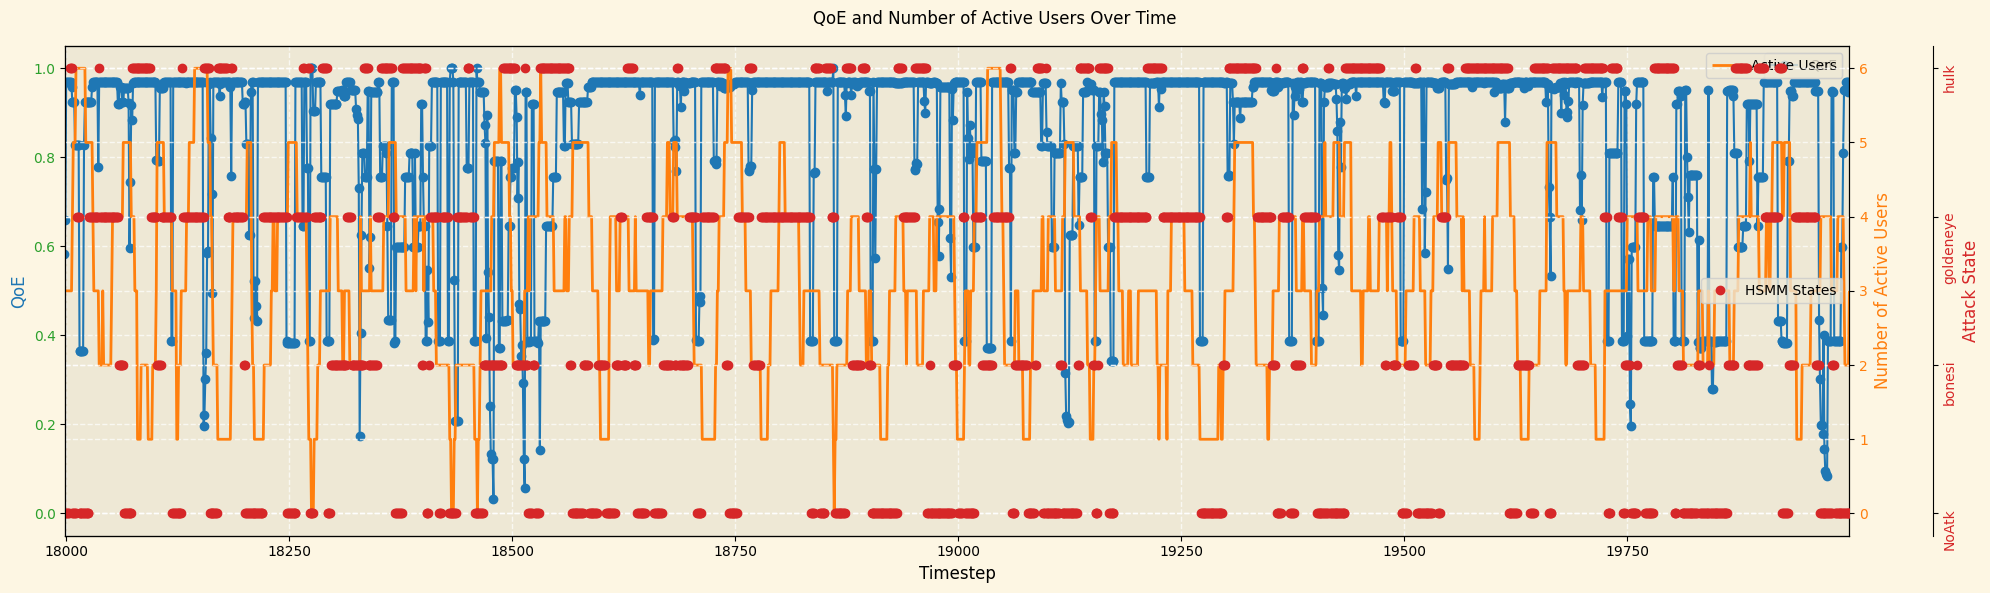

19999


array([[0.777     , 0.33333334, 0.27272728, 0.95030075],
       [0.7395    , 0.33333334, 0.36363637, 0.9684906 ],
       [0.7335    , 0.33333334, 0.27272728, 0.9684906 ],
       [0.703     , 0.33333334, 0.36363637, 0.9684906 ],
       [0.712     , 0.5       , 0.27272728, 0.9458151 ]], dtype=float32)

In [1171]:
env.env.plot_qoe()
env.history

In [1163]:
I = generate_attack_intensity(
                        2000, baseline_intensity, fluctuation_intensity, spike_prob, spike_intensity,
                        persistence_coeffs, decay_factor, drop_prob, drop_intensity)
# plt.figure(figsize=(10,6))
# plt.plot(I)
# plt.plot(env.env.atk_intensity_list[-2000:]['old_intensity'])
# plt.plot(old_intensities = [item.old_intensity for item in env.env.atk_intensity_list[-2000:]])

In [1160]:
# env.env.atk_intensity_list[0].value['name']
env.env.atk_intensity_list[:20]["old_intensity"]

TypeError: list indices must be integers or slices, not str